In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import keras as ks
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau




2025-01-07 11:21:02.354794: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
db_path='./triple_mnist/'

def flatten_toarray(set):
    set_path=db_path+set
    sub_folders=os.listdir(set_path)

    imgs=[]
    labels=[]

    for folder in sub_folders:
        subfolder_path = os.path.join(set_path, folder)

        for img_file in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_file)

            flattened_img = (Image.open(img_path))
            flattened_img = (np.array((flattened_img).convert('L')))

            imgs.append(flattened_img)
            labels.append(int(folder))
            
    return np.array(imgs), np.array(labels)


f_train_imgs, f_train_labels = flatten_toarray('train')
f_test_imgs, f_test_labels = flatten_toarray('test')
f_val_imgs, f_val_labels = flatten_toarray('val')

f_train_imgs = f_train_imgs / 255.0
f_test_imgs = f_test_imgs / 255.0
f_val_imgs = f_val_imgs / 255.0

In [15]:
db_path='./triple_mnist/'

def splits_flatten_toarray(set):
    set_path=db_path+set
    sub_folders=os.listdir(set_path)

    imgs=[]
    labels=[]

    for folder in sub_folders:
        subfolder_path = os.path.join(set_path, folder)

        for img_file in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_file)

            img = Image.open(img_path).convert('L')
            
            width, height = img.size
            
            split_width = width // 3

            splits = [
                img.crop((i * split_width, 0, (i + 1) * split_width, height))
                for i in range(3)
            ]

            for i, split in enumerate(splits):
                imgs.append(np.array(split))  
                labels.append(int(folder[i]))

    return np.array(imgs), np.array(labels)


t_train_imgs, t_train_labels = splits_flatten_toarray('train')
t_test_imgs, t_test_labels = splits_flatten_toarray('test')
t_val_imgs, t_val_labels = splits_flatten_toarray('val')

t_train_imgs = t_train_imgs / 255.0
t_test_imgs = t_test_imgs / 255.0
t_val_imgs = t_val_imgs / 255.0

In [4]:
def generate_and_visualize(generator, latent_dim, num_images=16):
    noise = tf.random.normal([num_images, latent_dim])
    generated_images = generator(noise)
    generated_images = (generated_images + 1) / 2.0  # Rescale to [0, 1]
    
    # Visualize
    plt.figure(figsize=(4, 4))
    for i in range(num_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

In [5]:
# NO LABELS
def build_generator(z_dim):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=z_dim),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(84 * 84 * 1, activation='tanh'), #SHAPE
        layers.Reshape((84, 84, 1)) #SHAPE

    ])
    return model


def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(84,84,1)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.1))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

# GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = tf.keras.Sequential([generator, discriminator])
    return model

In [23]:
def old_train_gan(generator, discriminator, gan, train_images, latent_dim, epochs, batch_size, display_interval):

    for epoch in range(epochs):
        # Train discriminator
        real_images = train_images[np.random.randint(0, train_images.shape[0], batch_size)]
        real_labels = np.ones((batch_size, 1))
        
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_images = generator.predict(noise)
        fake_labels = np.zeros((batch_size, 1))
        
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
        
        # Print losses for each epoch
        print(f"Epoch {epoch+1}/{epochs} - D Loss: {d_loss[0]:.4f}, D Acc: {d_loss[1]*100:.2f}%, G Loss: {g_loss:.4f}")

        if epoch % 25 == 0:
            generate_and_visualize(generator, latent_dim)



In [24]:
# Hyperparameters
latent_dim = 100  # Size of the noise vector
batch_size = 64
epochs = 250
display_interval = 50

# Instantiate models
generator = build_generator(latent_dim)
discriminator = build_discriminator()
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])
gan = build_gan(generator, discriminator)
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='binary_crossentropy')

2/2 [==============================] - 0s 7ms/step
Epoch 1/250 - D Loss: 0.6924, D Acc: 38.28%, G Loss: 0.6948


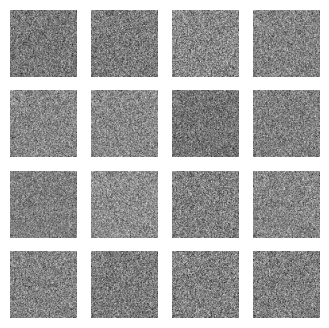

2/2 [==============================] - 0s 6ms/step
Epoch 2/250 - D Loss: 0.6843, D Acc: 50.00%, G Loss: 0.6777
2/2 [==============================] - 0s 7ms/step
Epoch 3/250 - D Loss: 0.6821, D Acc: 50.00%, G Loss: 0.6619
2/2 [==============================] - 0s 8ms/step
Epoch 4/250 - D Loss: 0.6779, D Acc: 50.00%, G Loss: 0.6470
2/2 [==============================] - 0s 7ms/step
Epoch 5/250 - D Loss: 0.6743, D Acc: 50.00%, G Loss: 0.6320
2/2 [==============================] - 0s 6ms/step
Epoch 6/250 - D Loss: 0.6742, D Acc: 50.00%, G Loss: 0.6197
2/2 [==============================] - 0s 6ms/step
Epoch 7/250 - D Loss: 0.6682, D Acc: 50.00%, G Loss: 0.6060
2/2 [==============================] - 0s 6ms/step
Epoch 8/250 - D Loss: 0.6644, D Acc: 50.00%, G Loss: 0.5948
2/2 [==============================] - 0s 6ms/step
Epoch 9/250 - D Loss: 0.6602, D Acc: 50.00%, G Loss: 0.5836
2/2 [==============================] - 0s 8ms/step
Epoch 10/250 - D Loss: 0.6564, D Acc: 50.00%, G Loss: 0.5723


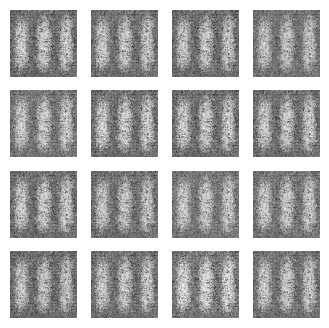

2/2 [==============================] - 0s 7ms/step
Epoch 27/250 - D Loss: 0.4317, D Acc: 86.72%, G Loss: 2.1140
2/2 [==============================] - 0s 6ms/step
Epoch 28/250 - D Loss: 0.4391, D Acc: 81.25%, G Loss: 2.0882
2/2 [==============================] - 0s 13ms/step
Epoch 29/250 - D Loss: 0.4348, D Acc: 87.50%, G Loss: 2.0256
2/2 [==============================] - 0s 7ms/step
Epoch 30/250 - D Loss: 0.4505, D Acc: 85.94%, G Loss: 1.9988
2/2 [==============================] - 0s 7ms/step
Epoch 31/250 - D Loss: 0.4459, D Acc: 87.50%, G Loss: 1.9311
2/2 [==============================] - 0s 6ms/step
Epoch 32/250 - D Loss: 0.4560, D Acc: 85.16%, G Loss: 1.8945
2/2 [==============================] - 0s 6ms/step
Epoch 33/250 - D Loss: 0.4524, D Acc: 85.16%, G Loss: 1.8952
2/2 [==============================] - 0s 10ms/step
Epoch 34/250 - D Loss: 0.4537, D Acc: 86.72%, G Loss: 1.8394
2/2 [==============================] - 0s 7ms/step
Epoch 35/250 - D Loss: 0.4590, D Acc: 86.72%, G Los

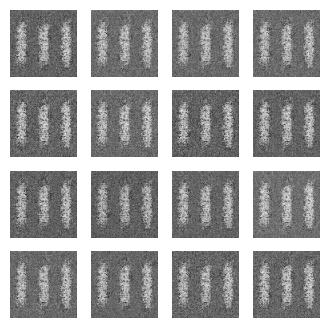

2/2 [==============================] - 0s 7ms/step
Epoch 52/250 - D Loss: 0.3886, D Acc: 98.44%, G Loss: 1.6766
2/2 [==============================] - 0s 12ms/step
Epoch 53/250 - D Loss: 0.3831, D Acc: 98.44%, G Loss: 1.6527
2/2 [==============================] - 0s 6ms/step
Epoch 54/250 - D Loss: 0.3884, D Acc: 99.22%, G Loss: 1.6446
2/2 [==============================] - 0s 8ms/step
Epoch 55/250 - D Loss: 0.3572, D Acc: 100.00%, G Loss: 1.6632
2/2 [==============================] - 0s 6ms/step
Epoch 56/250 - D Loss: 0.3686, D Acc: 99.22%, G Loss: 1.6780
2/2 [==============================] - 0s 6ms/step
Epoch 57/250 - D Loss: 0.3621, D Acc: 100.00%, G Loss: 1.6705
2/2 [==============================] - 0s 6ms/step
Epoch 58/250 - D Loss: 0.3559, D Acc: 99.22%, G Loss: 1.7191
2/2 [==============================] - 0s 6ms/step
Epoch 59/250 - D Loss: 0.3455, D Acc: 100.00%, G Loss: 1.7739
2/2 [==============================] - 0s 6ms/step
Epoch 60/250 - D Loss: 0.3326, D Acc: 100.00%, G 

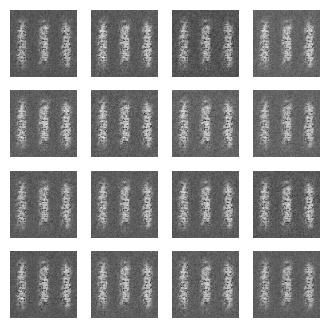

2/2 [==============================] - 0s 6ms/step
Epoch 77/250 - D Loss: 0.2945, D Acc: 100.00%, G Loss: 1.7430
2/2 [==============================] - 0s 6ms/step
Epoch 78/250 - D Loss: 0.3074, D Acc: 100.00%, G Loss: 1.7727
2/2 [==============================] - 0s 7ms/step
Epoch 79/250 - D Loss: 0.3057, D Acc: 100.00%, G Loss: 1.7606
2/2 [==============================] - 0s 6ms/step
Epoch 80/250 - D Loss: 0.3023, D Acc: 100.00%, G Loss: 1.7435
2/2 [==============================] - 0s 5ms/step
Epoch 81/250 - D Loss: 0.2864, D Acc: 100.00%, G Loss: 1.7555
2/2 [==============================] - 0s 6ms/step
Epoch 82/250 - D Loss: 0.3082, D Acc: 98.44%, G Loss: 1.7275
2/2 [==============================] - 0s 6ms/step
Epoch 83/250 - D Loss: 0.2945, D Acc: 99.22%, G Loss: 1.7058
2/2 [==============================] - 0s 6ms/step
Epoch 84/250 - D Loss: 0.2963, D Acc: 98.44%, G Loss: 1.7520
2/2 [==============================] - 0s 6ms/step
Epoch 85/250 - D Loss: 0.3067, D Acc: 100.00%, G

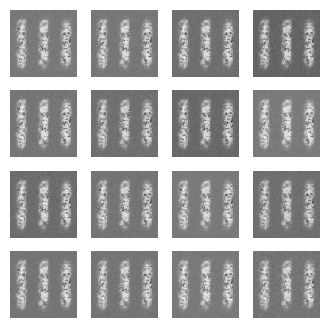

2/2 [==============================] - 0s 16ms/step
Epoch 102/250 - D Loss: 0.2791, D Acc: 100.00%, G Loss: 2.0069
2/2 [==============================] - 0s 6ms/step
Epoch 103/250 - D Loss: 0.2992, D Acc: 99.22%, G Loss: 1.9891
2/2 [==============================] - 0s 6ms/step
Epoch 104/250 - D Loss: 0.2866, D Acc: 100.00%, G Loss: 2.0067
2/2 [==============================] - 0s 7ms/step
Epoch 105/250 - D Loss: 0.3178, D Acc: 96.88%, G Loss: 1.9940
2/2 [==============================] - 0s 6ms/step
Epoch 106/250 - D Loss: 0.3044, D Acc: 100.00%, G Loss: 1.9353
2/2 [==============================] - 0s 5ms/step
Epoch 107/250 - D Loss: 0.2933, D Acc: 99.22%, G Loss: 1.9671
2/2 [==============================] - 0s 7ms/step
Epoch 108/250 - D Loss: 0.3013, D Acc: 97.66%, G Loss: 2.0057
2/2 [==============================] - 0s 6ms/step
Epoch 109/250 - D Loss: 0.2987, D Acc: 98.44%, G Loss: 1.9656
2/2 [==============================] - 0s 7ms/step
Epoch 110/250 - D Loss: 0.3160, D Acc: 97

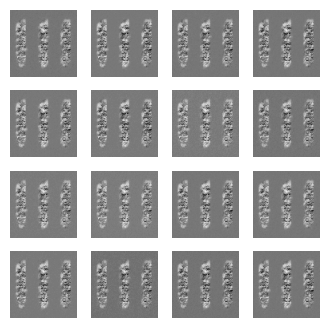

2/2 [==============================] - 0s 6ms/step
Epoch 127/250 - D Loss: 0.3084, D Acc: 100.00%, G Loss: 1.7166
2/2 [==============================] - 0s 9ms/step
Epoch 128/250 - D Loss: 0.3267, D Acc: 99.22%, G Loss: 1.7072
2/2 [==============================] - 0s 7ms/step
Epoch 129/250 - D Loss: 0.3082, D Acc: 99.22%, G Loss: 1.7064
2/2 [==============================] - 0s 6ms/step
Epoch 130/250 - D Loss: 0.3009, D Acc: 99.22%, G Loss: 1.6763
2/2 [==============================] - 0s 5ms/step
Epoch 131/250 - D Loss: 0.3071, D Acc: 100.00%, G Loss: 1.6961
2/2 [==============================] - 0s 6ms/step
Epoch 132/250 - D Loss: 0.2945, D Acc: 100.00%, G Loss: 1.6653
2/2 [==============================] - 0s 7ms/step
Epoch 133/250 - D Loss: 0.2894, D Acc: 100.00%, G Loss: 1.6338
2/2 [==============================] - 0s 6ms/step
Epoch 134/250 - D Loss: 0.2739, D Acc: 100.00%, G Loss: 1.6144
2/2 [==============================] - 0s 6ms/step
Epoch 135/250 - D Loss: 0.2766, D Acc: 1

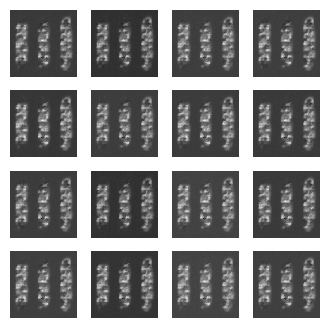

2/2 [==============================] - 0s 6ms/step
Epoch 152/250 - D Loss: 0.3230, D Acc: 100.00%, G Loss: 1.6655
2/2 [==============================] - 0s 7ms/step
Epoch 153/250 - D Loss: 0.3139, D Acc: 100.00%, G Loss: 1.7082
2/2 [==============================] - 0s 6ms/step
Epoch 154/250 - D Loss: 0.3099, D Acc: 99.22%, G Loss: 1.7847
2/2 [==============================] - 0s 6ms/step
Epoch 155/250 - D Loss: 0.3020, D Acc: 99.22%, G Loss: 1.7496
2/2 [==============================] - 0s 6ms/step
Epoch 156/250 - D Loss: 0.3188, D Acc: 99.22%, G Loss: 1.7528
2/2 [==============================] - 0s 6ms/step
Epoch 157/250 - D Loss: 0.2884, D Acc: 100.00%, G Loss: 1.7812
2/2 [==============================] - 0s 5ms/step
Epoch 158/250 - D Loss: 0.2966, D Acc: 100.00%, G Loss: 1.8278
2/2 [==============================] - 0s 6ms/step
Epoch 159/250 - D Loss: 0.3003, D Acc: 100.00%, G Loss: 1.8320
2/2 [==============================] - 0s 6ms/step
Epoch 160/250 - D Loss: 0.2734, D Acc: 1

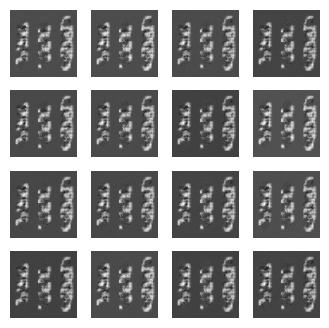

2/2 [==============================] - 0s 6ms/step
Epoch 177/250 - D Loss: 0.1662, D Acc: 100.00%, G Loss: 2.4220
2/2 [==============================] - 0s 7ms/step
Epoch 178/250 - D Loss: 0.1607, D Acc: 100.00%, G Loss: 2.3448
2/2 [==============================] - 0s 6ms/step
Epoch 179/250 - D Loss: 0.1442, D Acc: 100.00%, G Loss: 2.3786
2/2 [==============================] - 0s 7ms/step
Epoch 180/250 - D Loss: 0.1425, D Acc: 100.00%, G Loss: 2.4261
2/2 [==============================] - 0s 6ms/step
Epoch 181/250 - D Loss: 0.1496, D Acc: 100.00%, G Loss: 2.4030
2/2 [==============================] - 0s 6ms/step
Epoch 182/250 - D Loss: 0.1489, D Acc: 100.00%, G Loss: 2.4409
2/2 [==============================] - 0s 6ms/step
Epoch 183/250 - D Loss: 0.1915, D Acc: 99.22%, G Loss: 2.2344
2/2 [==============================] - 0s 6ms/step
Epoch 184/250 - D Loss: 0.1760, D Acc: 100.00%, G Loss: 2.2189
2/2 [==============================] - 0s 6ms/step
Epoch 185/250 - D Loss: 0.1830, D Acc:

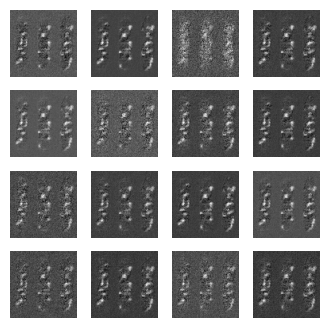

2/2 [==============================] - 0s 6ms/step
Epoch 202/250 - D Loss: 0.1478, D Acc: 100.00%, G Loss: 2.2209
2/2 [==============================] - 0s 6ms/step
Epoch 203/250 - D Loss: 0.1466, D Acc: 100.00%, G Loss: 2.3676
2/2 [==============================] - 0s 6ms/step
Epoch 204/250 - D Loss: 0.1417, D Acc: 100.00%, G Loss: 2.3160
2/2 [==============================] - 0s 5ms/step
Epoch 205/250 - D Loss: 0.1318, D Acc: 100.00%, G Loss: 2.4357
2/2 [==============================] - 0s 40ms/step
Epoch 206/250 - D Loss: 0.1160, D Acc: 100.00%, G Loss: 2.4752
2/2 [==============================] - 0s 6ms/step
Epoch 207/250 - D Loss: 0.1064, D Acc: 100.00%, G Loss: 2.4353
2/2 [==============================] - 0s 6ms/step
Epoch 208/250 - D Loss: 0.0945, D Acc: 100.00%, G Loss: 2.4932
2/2 [==============================] - 0s 21ms/step
Epoch 209/250 - D Loss: 0.0898, D Acc: 100.00%, G Loss: 2.5923
2/2 [==============================] - 0s 6ms/step
Epoch 210/250 - D Loss: 0.0820, D A

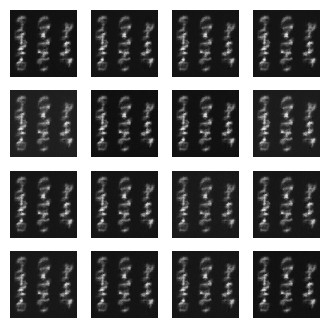

2/2 [==============================] - 0s 7ms/step
Epoch 227/250 - D Loss: 0.6733, D Acc: 61.72%, G Loss: 1.5729
2/2 [==============================] - 0s 7ms/step
Epoch 228/250 - D Loss: 0.7758, D Acc: 58.59%, G Loss: 1.3520
2/2 [==============================] - 0s 6ms/step
Epoch 229/250 - D Loss: 1.0005, D Acc: 36.72%, G Loss: 1.1391
2/2 [==============================] - 0s 6ms/step
Epoch 230/250 - D Loss: 0.8509, D Acc: 48.44%, G Loss: 1.0883
2/2 [==============================] - 0s 6ms/step
Epoch 231/250 - D Loss: 0.8676, D Acc: 45.31%, G Loss: 1.2299
2/2 [==============================] - 0s 6ms/step
Epoch 232/250 - D Loss: 0.7449, D Acc: 46.88%, G Loss: 1.5025
2/2 [==============================] - 0s 6ms/step
Epoch 233/250 - D Loss: 0.6789, D Acc: 57.81%, G Loss: 1.8116
2/2 [==============================] - 0s 6ms/step
Epoch 234/250 - D Loss: 0.5846, D Acc: 68.75%, G Loss: 2.0268
2/2 [==============================] - 0s 6ms/step
Epoch 235/250 - D Loss: 0.4323, D Acc: 80.47%

In [25]:
old_train_gan(generator, discriminator, gan, f_train_imgs, latent_dim, epochs, batch_size, display_interval)

In [12]:
# NO LABELS
def _build_generator(z_dim):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=z_dim),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(84 * 28 * 1, activation='tanh'), #SHAPE
        layers.Reshape((84, 28, 1)) #SHAPE

    ])
    return model


def _build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(84,28,1)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.1))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model


In [26]:
def _old_train_gan(generator, discriminator, gan, train_images, latent_dim, epochs, batch_size, display_interval):

    for epoch in range(epochs):
        # Train discriminator
        real_images = train_images[np.random.randint(0, train_images.shape[0], batch_size)]
        real_labels = np.ones((batch_size, 1))
        
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_images = generator.predict(noise)
        fake_labels = np.zeros((batch_size, 1))
        
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
        
        # Print losses for each epoch
        print(f"Epoch {epoch+1}/{epochs} - D Loss: {d_loss[0]:.4f}, D Acc: {d_loss[1]*100:.2f}%, G Loss: {g_loss:.4f}")

        if epoch % 25 == 0:
            generate_and_visualize(generator, latent_dim)



In [27]:
# Hyperparameters
latent_dim = 100  # Size of the noise vector
batch_size = 64
epochs = 250
display_interval = 50

# Instantiate models
generator = _build_generator(latent_dim)
discriminator = _build_discriminator()
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])
gan = build_gan(generator, discriminator)
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='binary_crossentropy')

2/2 [==============================] - 0s 6ms/step
Epoch 1/250 - D Loss: 0.6946, D Acc: 35.16%, G Loss: 0.7027


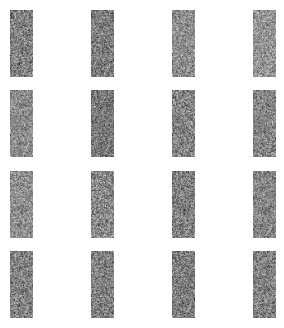

2/2 [==============================] - 0s 4ms/step
Epoch 2/250 - D Loss: 0.6923, D Acc: 46.88%, G Loss: 0.6976
2/2 [==============================] - 0s 4ms/step
Epoch 3/250 - D Loss: 0.6899, D Acc: 47.66%, G Loss: 0.6930
2/2 [==============================] - 0s 5ms/step
Epoch 4/250 - D Loss: 0.6893, D Acc: 46.88%, G Loss: 0.6905
2/2 [==============================] - 0s 5ms/step
Epoch 5/250 - D Loss: 0.6883, D Acc: 47.66%, G Loss: 0.6892
2/2 [==============================] - 0s 4ms/step
Epoch 6/250 - D Loss: 0.6878, D Acc: 48.44%, G Loss: 0.6860
2/2 [==============================] - 0s 4ms/step
Epoch 7/250 - D Loss: 0.6842, D Acc: 50.00%, G Loss: 0.6855
2/2 [==============================] - 0s 5ms/step
Epoch 8/250 - D Loss: 0.6854, D Acc: 49.22%, G Loss: 0.6863
2/2 [==============================] - 0s 4ms/step
Epoch 9/250 - D Loss: 0.6807, D Acc: 50.00%, G Loss: 0.6884
2/2 [==============================] - 0s 5ms/step
Epoch 10/250 - D Loss: 0.6786, D Acc: 50.78%, G Loss: 0.6905


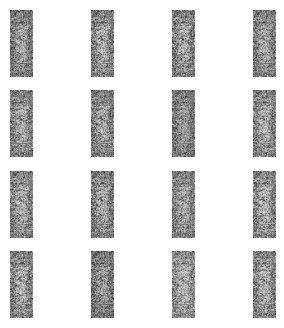

2/2 [==============================] - 0s 5ms/step
Epoch 27/250 - D Loss: 0.5410, D Acc: 96.88%, G Loss: 1.1440
2/2 [==============================] - 0s 9ms/step
Epoch 28/250 - D Loss: 0.5245, D Acc: 96.09%, G Loss: 1.1812
2/2 [==============================] - 0s 5ms/step
Epoch 29/250 - D Loss: 0.5145, D Acc: 97.66%, G Loss: 1.2270
2/2 [==============================] - 0s 6ms/step
Epoch 30/250 - D Loss: 0.5101, D Acc: 94.53%, G Loss: 1.2698
2/2 [==============================] - 0s 7ms/step
Epoch 31/250 - D Loss: 0.5094, D Acc: 94.53%, G Loss: 1.3063
2/2 [==============================] - 0s 4ms/step
Epoch 32/250 - D Loss: 0.5205, D Acc: 86.72%, G Loss: 1.3574
2/2 [==============================] - 0s 5ms/step
Epoch 33/250 - D Loss: 0.5060, D Acc: 91.41%, G Loss: 1.4120
2/2 [==============================] - 0s 6ms/step
Epoch 34/250 - D Loss: 0.5046, D Acc: 89.84%, G Loss: 1.4356
2/2 [==============================] - 0s 4ms/step
Epoch 35/250 - D Loss: 0.4986, D Acc: 89.84%, G Loss:

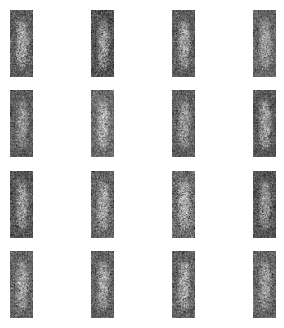

2/2 [==============================] - 0s 6ms/step
Epoch 52/250 - D Loss: 0.4609, D Acc: 94.53%, G Loss: 1.4561
2/2 [==============================] - 0s 5ms/step
Epoch 53/250 - D Loss: 0.4494, D Acc: 96.88%, G Loss: 1.4336
2/2 [==============================] - 0s 9ms/step
Epoch 54/250 - D Loss: 0.4545, D Acc: 93.75%, G Loss: 1.4030
2/2 [==============================] - 0s 6ms/step
Epoch 55/250 - D Loss: 0.4438, D Acc: 96.09%, G Loss: 1.4003
2/2 [==============================] - 0s 14ms/step
Epoch 56/250 - D Loss: 0.4350, D Acc: 96.88%, G Loss: 1.3969
2/2 [==============================] - 0s 7ms/step
Epoch 57/250 - D Loss: 0.4377, D Acc: 97.66%, G Loss: 1.3903
2/2 [==============================] - 0s 5ms/step
Epoch 58/250 - D Loss: 0.4235, D Acc: 99.22%, G Loss: 1.3752
2/2 [==============================] - 0s 7ms/step
Epoch 59/250 - D Loss: 0.4263, D Acc: 98.44%, G Loss: 1.3783
2/2 [==============================] - 0s 4ms/step
Epoch 60/250 - D Loss: 0.4100, D Acc: 100.00%, G Los

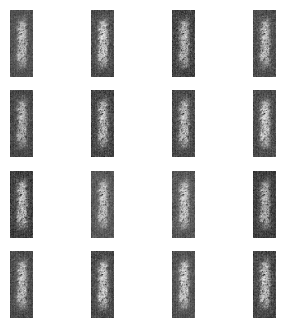

2/2 [==============================] - 0s 5ms/step
Epoch 77/250 - D Loss: 0.4059, D Acc: 96.09%, G Loss: 1.5690
2/2 [==============================] - 0s 4ms/step
Epoch 78/250 - D Loss: 0.4133, D Acc: 93.75%, G Loss: 1.5786
2/2 [==============================] - 0s 4ms/step
Epoch 79/250 - D Loss: 0.4189, D Acc: 91.41%, G Loss: 1.6040
2/2 [==============================] - 0s 4ms/step
Epoch 80/250 - D Loss: 0.4332, D Acc: 92.19%, G Loss: 1.5835
2/2 [==============================] - 0s 8ms/step
Epoch 81/250 - D Loss: 0.4592, D Acc: 89.84%, G Loss: 1.5710
2/2 [==============================] - 0s 6ms/step
Epoch 82/250 - D Loss: 0.4029, D Acc: 93.75%, G Loss: 1.6570
2/2 [==============================] - 0s 5ms/step
Epoch 83/250 - D Loss: 0.3741, D Acc: 96.88%, G Loss: 1.6538
2/2 [==============================] - 0s 5ms/step
Epoch 84/250 - D Loss: 0.3973, D Acc: 93.75%, G Loss: 1.6722
2/2 [==============================] - 0s 4ms/step
Epoch 85/250 - D Loss: 0.3722, D Acc: 95.31%, G Loss:

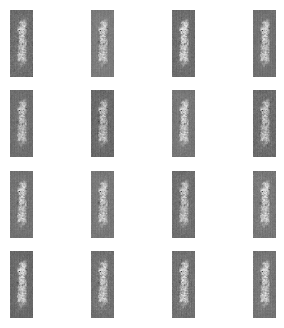

2/2 [==============================] - 0s 4ms/step
Epoch 102/250 - D Loss: 0.3844, D Acc: 96.09%, G Loss: 1.5792
2/2 [==============================] - 0s 4ms/step
Epoch 103/250 - D Loss: 0.3869, D Acc: 96.88%, G Loss: 1.5539
2/2 [==============================] - 0s 4ms/step
Epoch 104/250 - D Loss: 0.4427, D Acc: 93.75%, G Loss: 1.5206
2/2 [==============================] - 0s 4ms/step
Epoch 105/250 - D Loss: 0.4247, D Acc: 96.88%, G Loss: 1.4552
2/2 [==============================] - 0s 4ms/step
Epoch 106/250 - D Loss: 0.4298, D Acc: 96.09%, G Loss: 1.4449
2/2 [==============================] - 0s 4ms/step
Epoch 107/250 - D Loss: 0.4322, D Acc: 98.44%, G Loss: 1.4487
2/2 [==============================] - 0s 4ms/step
Epoch 108/250 - D Loss: 0.4672, D Acc: 92.97%, G Loss: 1.3670
2/2 [==============================] - 0s 4ms/step
Epoch 109/250 - D Loss: 0.4750, D Acc: 93.75%, G Loss: 1.3409
2/2 [==============================] - 0s 4ms/step
Epoch 110/250 - D Loss: 0.4487, D Acc: 95.31%

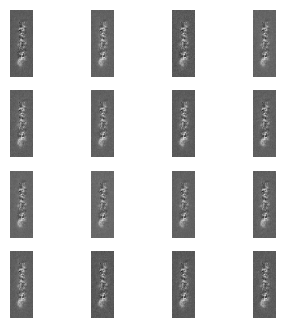

2/2 [==============================] - 0s 4ms/step
Epoch 127/250 - D Loss: 0.4609, D Acc: 98.44%, G Loss: 1.0741
2/2 [==============================] - 0s 4ms/step
Epoch 128/250 - D Loss: 0.4607, D Acc: 96.09%, G Loss: 1.0829
2/2 [==============================] - 0s 4ms/step
Epoch 129/250 - D Loss: 0.4650, D Acc: 98.44%, G Loss: 1.0736
2/2 [==============================] - 0s 4ms/step
Epoch 130/250 - D Loss: 0.4774, D Acc: 95.31%, G Loss: 1.0481
2/2 [==============================] - 0s 4ms/step
Epoch 131/250 - D Loss: 0.4671, D Acc: 96.88%, G Loss: 1.0324
2/2 [==============================] - 0s 5ms/step
Epoch 132/250 - D Loss: 0.4780, D Acc: 95.31%, G Loss: 1.0478
2/2 [==============================] - 0s 13ms/step
Epoch 133/250 - D Loss: 0.4533, D Acc: 97.66%, G Loss: 1.0626
2/2 [==============================] - 0s 6ms/step
Epoch 134/250 - D Loss: 0.4549, D Acc: 98.44%, G Loss: 1.0380
2/2 [==============================] - 0s 4ms/step
Epoch 135/250 - D Loss: 0.4538, D Acc: 97.66

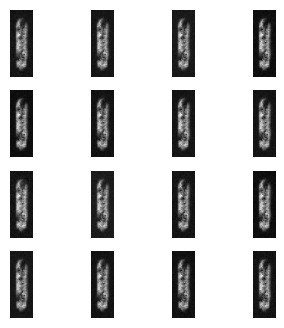

2/2 [==============================] - 0s 8ms/step
Epoch 152/250 - D Loss: 0.4471, D Acc: 95.31%, G Loss: 1.3477
2/2 [==============================] - 0s 5ms/step
Epoch 153/250 - D Loss: 0.4556, D Acc: 92.19%, G Loss: 1.3967
2/2 [==============================] - 0s 6ms/step
Epoch 154/250 - D Loss: 0.4426, D Acc: 92.97%, G Loss: 1.4270
2/2 [==============================] - 0s 6ms/step
Epoch 155/250 - D Loss: 0.4759, D Acc: 89.06%, G Loss: 1.4427
2/2 [==============================] - 0s 5ms/step
Epoch 156/250 - D Loss: 0.4495, D Acc: 91.41%, G Loss: 1.4517
2/2 [==============================] - 0s 4ms/step
Epoch 157/250 - D Loss: 0.4604, D Acc: 89.84%, G Loss: 1.4560
2/2 [==============================] - 0s 6ms/step
Epoch 158/250 - D Loss: 0.4199, D Acc: 93.75%, G Loss: 1.4889
2/2 [==============================] - 0s 4ms/step
Epoch 159/250 - D Loss: 0.4232, D Acc: 90.62%, G Loss: 1.4824
2/2 [==============================] - 0s 4ms/step
Epoch 160/250 - D Loss: 0.4297, D Acc: 89.06%

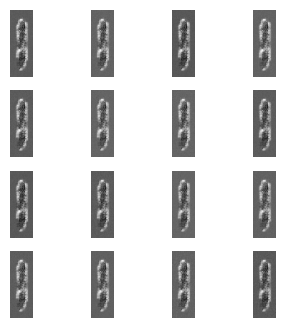

2/2 [==============================] - 0s 6ms/step
Epoch 177/250 - D Loss: 0.3646, D Acc: 97.66%, G Loss: 1.3488
2/2 [==============================] - 0s 5ms/step
Epoch 178/250 - D Loss: 0.3569, D Acc: 99.22%, G Loss: 1.3312
2/2 [==============================] - 0s 5ms/step
Epoch 179/250 - D Loss: 0.3518, D Acc: 97.66%, G Loss: 1.3232
2/2 [==============================] - 0s 4ms/step
Epoch 180/250 - D Loss: 0.3809, D Acc: 96.88%, G Loss: 1.3017
2/2 [==============================] - 0s 4ms/step
Epoch 181/250 - D Loss: 0.3593, D Acc: 100.00%, G Loss: 1.2585
2/2 [==============================] - 0s 4ms/step
Epoch 182/250 - D Loss: 0.3944, D Acc: 97.66%, G Loss: 1.2313
2/2 [==============================] - 0s 5ms/step
Epoch 183/250 - D Loss: 0.3611, D Acc: 98.44%, G Loss: 1.2303
2/2 [==============================] - 0s 4ms/step
Epoch 184/250 - D Loss: 0.3915, D Acc: 98.44%, G Loss: 1.2478
2/2 [==============================] - 0s 4ms/step
Epoch 185/250 - D Loss: 0.4022, D Acc: 97.66

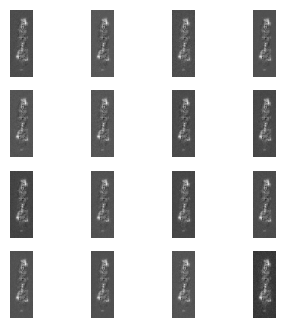

2/2 [==============================] - 0s 4ms/step
Epoch 202/250 - D Loss: 0.4416, D Acc: 95.31%, G Loss: 1.0175
2/2 [==============================] - 0s 7ms/step
Epoch 203/250 - D Loss: 0.4677, D Acc: 95.31%, G Loss: 0.9775
2/2 [==============================] - 0s 4ms/step
Epoch 204/250 - D Loss: 0.4381, D Acc: 95.31%, G Loss: 0.9799
2/2 [==============================] - 0s 4ms/step
Epoch 205/250 - D Loss: 0.4366, D Acc: 98.44%, G Loss: 0.9910
2/2 [==============================] - 0s 13ms/step
Epoch 206/250 - D Loss: 0.4548, D Acc: 96.88%, G Loss: 0.9973
2/2 [==============================] - 0s 4ms/step
Epoch 207/250 - D Loss: 0.4543, D Acc: 96.09%, G Loss: 0.9741
2/2 [==============================] - 0s 5ms/step
Epoch 208/250 - D Loss: 0.4537, D Acc: 98.44%, G Loss: 0.9604
2/2 [==============================] - 0s 4ms/step
Epoch 209/250 - D Loss: 0.4563, D Acc: 98.44%, G Loss: 0.9810
2/2 [==============================] - 0s 5ms/step
Epoch 210/250 - D Loss: 0.4432, D Acc: 97.66

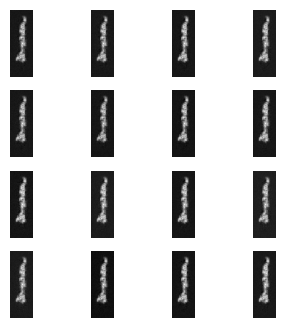

2/2 [==============================] - 0s 6ms/step
Epoch 227/250 - D Loss: 0.3759, D Acc: 95.31%, G Loss: 1.4211
2/2 [==============================] - 0s 5ms/step
Epoch 228/250 - D Loss: 0.3699, D Acc: 95.31%, G Loss: 1.4402
2/2 [==============================] - 0s 12ms/step
Epoch 229/250 - D Loss: 0.3850, D Acc: 92.97%, G Loss: 1.4767
2/2 [==============================] - 0s 6ms/step
Epoch 230/250 - D Loss: 0.3472, D Acc: 98.44%, G Loss: 1.4970
2/2 [==============================] - 0s 5ms/step
Epoch 231/250 - D Loss: 0.3361, D Acc: 96.88%, G Loss: 1.5451
2/2 [==============================] - 0s 6ms/step
Epoch 232/250 - D Loss: 0.3226, D Acc: 96.09%, G Loss: 1.5955
2/2 [==============================] - 0s 6ms/step
Epoch 233/250 - D Loss: 0.3202, D Acc: 96.88%, G Loss: 1.6347
2/2 [==============================] - 0s 4ms/step
Epoch 234/250 - D Loss: 0.3215, D Acc: 96.88%, G Loss: 1.6336
2/2 [==============================] - 0s 4ms/step
Epoch 235/250 - D Loss: 0.3380, D Acc: 95.31

In [28]:
_old_train_gan(generator, discriminator, gan, t_train_imgs, latent_dim, epochs, batch_size, display_interval)